# Лабораторная работа №4
## Выполнил: Концебалов О.С.
## Группа: М8О-409Б-22

## Случайный лес
### Для задачи классификации

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv('heart.csv')
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
baseline_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
baseline_rf.fit(X_train, y_train)
train_pred_baseline = baseline_rf.predict(X_train)
test_pred_baseline = baseline_rf.predict(X_test)
test_proba_baseline = baseline_rf.predict_proba(X_test)[:, 1]

print("base")
print(f"n est {baseline_rf.n_estimators}")
print(f"max depth{baseline_rf.max_depth}")
print(f"min split {baseline_rf.min_samples_split}")
print(f"min leaf {baseline_rf.min_samples_leaf}")
print("\ntrain")
print(f"accuracy {accuracy_score(y_train, train_pred_baseline):.4f}")
print(f"F1-score{f1_score(y_train, train_pred_baseline):.4f}")
print("\ntest")
print(f"accuracy  {accuracy_score(y_test, test_pred_baseline):.4f}")
print(f"F1-score {f1_score(y_test, test_pred_baseline):.4f}")
print(f"\naccuracy(Train-Test){accuracy_score(y_train, train_pred_baseline) - accuracy_score(y_test, test_pred_baseline):.4f}")

base
n est 100
max depthNone
min split 2
min leaf 1

train
accuracy 1.0000
F1-score1.0000

test
accuracy  1.0000
F1-score 1.0000

accuracy(Train-Test)0.0000


Метрики идеальные с самого начала, попробуем поизучать и немного их поухудшать

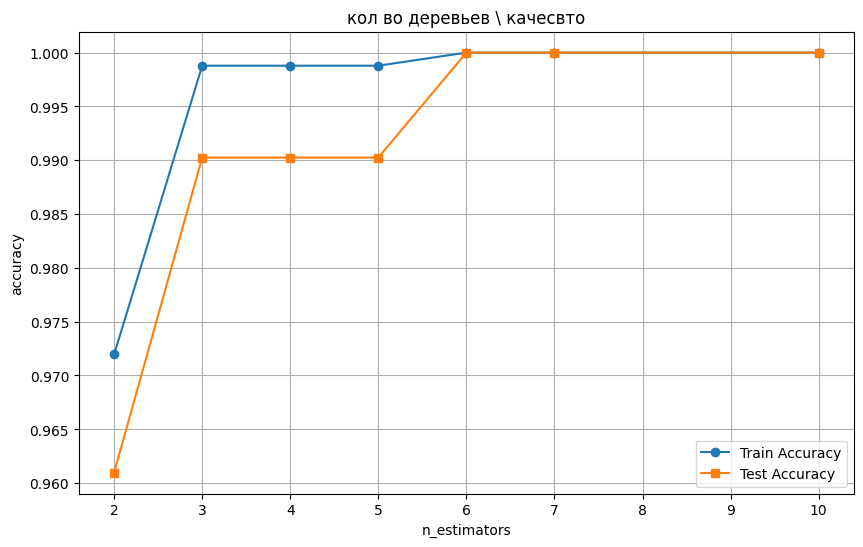

In [12]:
n_estimators_range = [2,3,4,5,6,7,10]
train_scores = []
test_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_scores, label='Test Accuracy', marker='s')
plt.xlabel('n_estimators')
plt.ylabel('аccuracy')
plt.title('кол во деревьев \ качесвто')
plt.legend()
plt.grid(True)
plt.show()

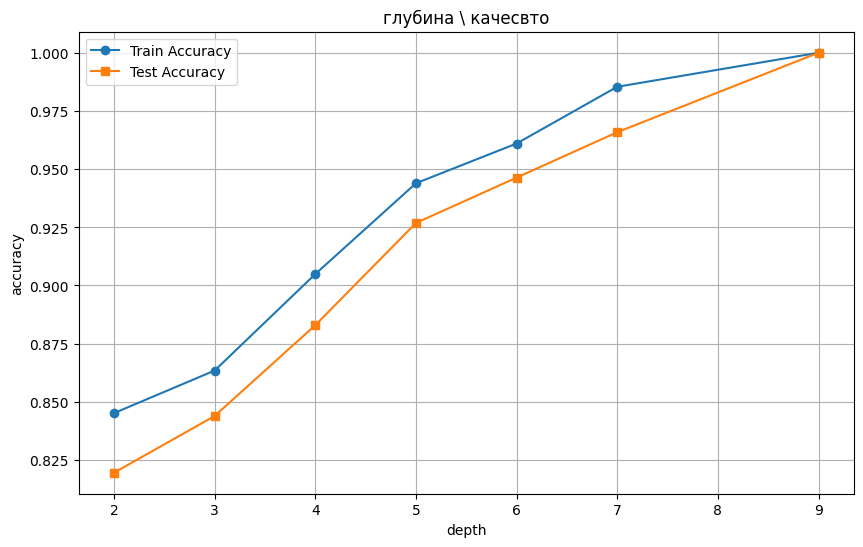

In [61]:
max_depth_range = [2,3,4,5,6,7,9]
train_scores = []
test_scores = []

for k in max_depth_range:
    rf = RandomForestClassifier(n_estimators=6, max_depth = k,random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_scores, label='Train Accuracy', marker='o')
plt.plot(max_depth_range, test_scores, label='Test Accuracy', marker='s')
plt.xlabel('depth')
plt.ylabel('аccuracy')
plt.title('глубина \ качесвто')
plt.legend()
plt.grid(True)
plt.show()

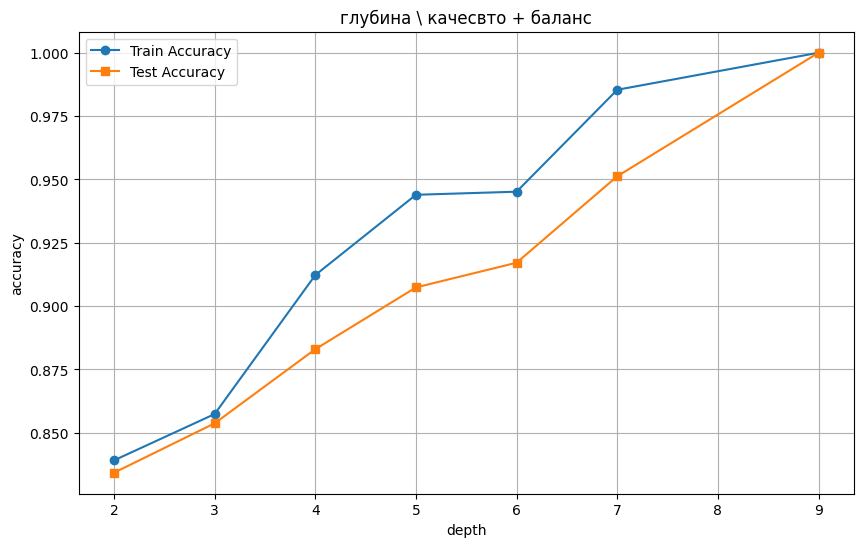

In [64]:
max_depth_range = [2,3,4,5,6,7,9]
train_scores = []
test_scores = []

for k in max_depth_range:
    rf = RandomForestClassifier(class_weight='balanced', n_estimators=6, max_depth = k,random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, train_scores, label='Train Accuracy', marker='o')
plt.plot(max_depth_range, test_scores, label='Test Accuracy', marker='s')
plt.xlabel('depth')
plt.ylabel('аccuracy')
plt.title('глубина \ качесвто + баланс')
plt.legend()
plt.grid(True)
plt.show()

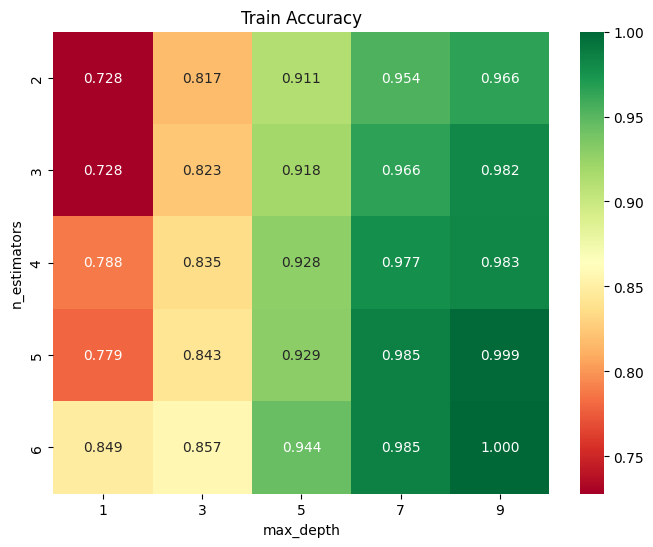

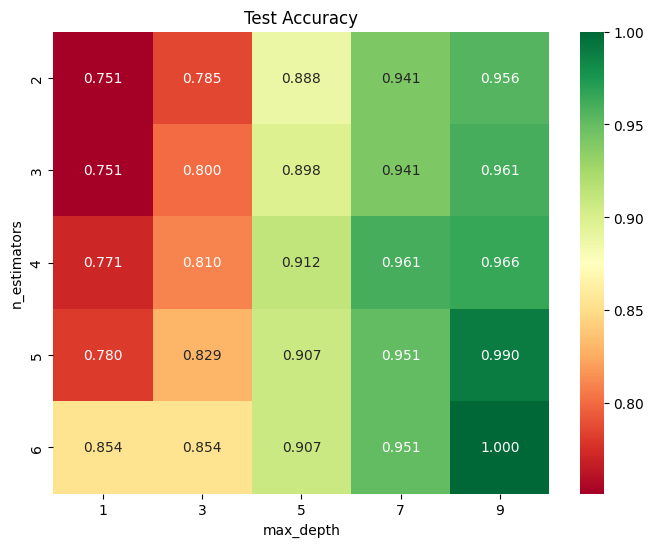

In [67]:
import pandas as pd
import seaborn as sns

max_depth_range = [1,3,5,7,9]
n_estimators_range = [2,3,4,5,6]

results = []

for depth in max_depth_range:
    for n in n_estimators_range:
        rf = RandomForestClassifier(class_weight='balanced', n_estimators=n, max_depth=depth, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, rf.predict(X_train))
        test_acc = accuracy_score(y_test, rf.predict(X_test))
        results.append({
            'max_depth': depth,
            'n_estimators': n,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'diff': train_acc - test_acc
        })

df_results = pd.DataFrame(results)

pivot_train = df_results.pivot(index='n_estimators', columns='max_depth', values='train_accuracy')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_train, annot=True, fmt='.3f', cmap='RdYlGn')
plt.title('Train Accuracy')
plt.show()
pivot_test = df_results.pivot(index='n_estimators', columns='max_depth', values='test_accuracy')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_test, annot=True, fmt='.3f', cmap='RdYlGn')
plt.title('Test Accuracy')
plt.show()

Подобного рода датасеты дают прекрасную возможность изучить влияние параметров на решение, перейдем к своей реализации

In [68]:
class CustomRandomForest:
    def __init__(self, n_estimators=100, max_depth=None, max_features='sqrt',
                 min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_feature_subset(self, n_features):
        if isinstance(self.max_features, int):
            n_selected = min(self.max_features, n_features)
        elif self.max_features == 'sqrt':
            n_selected = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_selected = int(np.log2(n_features)) + 1
        else:
            n_selected = n_features
        
        return np.random.choice(n_features, n_selected, replace=False)
    
    def _build_tree(self, X, y, depth=0):
        if (self.max_depth is not None and depth >= self.max_depth or
            len(y) < self.min_samples_split or
            len(np.unique(y)) == 1):
            return {'value': np.round(np.mean(y)), 'is_leaf': True}
        
        n_features = X.shape[1]
        feature_indices = self._get_feature_subset(n_features)
        
        best_gini = float('inf')
        best_feature, best_threshold = None, None
        best_left_indices, best_right_indices = None, None
        
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] <= threshold
                right_indices = X[:, feature_idx] > threshold
                
                if (np.sum(left_indices) < self.min_samples_leaf or
                    np.sum(right_indices) < self.min_samples_leaf):
                    continue
                
                # Вычисляем Gini impurity
                left_p = np.sum(y[left_indices] == 1) / max(1, np.sum(left_indices))
                right_p = np.sum(y[right_indices] == 1) / max(1, np.sum(right_indices))
                
                gini_left = 1 - left_p**2 - (1-left_p)**2
                gini_right = 1 - right_p**2 - (1-right_p)**2
                
                weighted_gini = (np.sum(left_indices) * gini_left + 
                                np.sum(right_indices) * gini_right) / len(y)
                
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_left_indices = left_indices
                    best_right_indices = right_indices
        
        if best_feature is None:
            return {'value': np.round(np.mean(y)), 'is_leaf': True}
        
        left_subtree = self._build_tree(X[best_left_indices], y[best_left_indices], depth + 1)
        right_subtree = self._build_tree(X[best_right_indices], y[best_right_indices], depth + 1)
        
        return {
            'feature_index': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'is_leaf': False
        }
    
    def fit(self, X, y):
        X_array = np.array(X)
        y_array = np.array(y)
        
        self.trees = []
        self.feature_indices = []
        
        for i in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X_array, y_array)
            tree = self._build_tree(X_boot, y_boot)
            self.trees.append(tree)
    
    def _predict_tree(self, x, tree):
        if tree['is_leaf']:
            return tree['value']
        
        if x[tree['feature_index']] <= tree['threshold']:
            return self._predict_tree(x, tree['left'])
        else:
            return self._predict_tree(x, tree['right'])
    
    def predict(self, X):
        X_array = np.array(X)
        predictions = []
        
        for x in X_array:
            tree_predictions = []
            for tree in self.trees:
                tree_predictions.append(self._predict_tree(x, tree))
            avg_prediction = np.mean(tree_predictions)
            predictions.append(1 if avg_prediction > 0.5 else 0)
        
        return np.array(predictions)
    
custom_rf = CustomRandomForest(
    n_estimators=50,  
    max_depth=10,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

custom_rf.fit(X_train, y_train)

y_pred_custom_rf = custom_rf.predict(X_test)

print("my")
print(f"accuracy {accuracy_score(y_test, y_pred_custom_rf):.4f}")
print(f"F1-score {f1_score(y_test, y_pred_custom_rf):.4f}")

my
accuracy 1.0000
F1-score 1.0000


Отличный результат, подберем более сбалансированные параметры, например, по аналогии с количеством деревьев

In [69]:
n_trees_options = [10, 15, 20, 25, 30]
best_custom_rf_score = 0
best_n_trees = 50

for n_trees in n_trees_options:
    rf = CustomRandomForest(
        n_estimators=n_trees,
        max_depth=10,
        max_features='sqrt',
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred)
    
    print(f"n_estimators={n_trees}   F1-score={score:.4f}")
    
    if score > best_custom_rf_score:
        best_custom_rf_score = score
        best_n_trees = n_trees

final_custom_rf = CustomRandomForest(
    n_estimators=best_n_trees,
    max_depth=10,
    max_features='sqrt',
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

final_custom_rf.fit(X_train, y_train)
y_pred_final_custom_rf = final_custom_rf.predict(X_test)

n_estimators=10   F1-score=0.9714
n_estimators=15   F1-score=0.9714
n_estimators=20   F1-score=0.9662
n_estimators=25   F1-score=0.9906
n_estimators=30   F1-score=1.0000


### Для задачи регрессии

Обучим базовую модель

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_id = train['Id']
test_id = test['Id']

y = train['SalePrice'].copy()
X = train.drop(['Id', 'SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

def prepare_data_baseline(X_train, X_val):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()
    
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train[col], X_val[col]], axis=0).fillna('Missing')
        le.fit(combined)
        X_train_processed[col] = le.transform(X_train[col].fillna('Missing'))
        X_val_processed[col] = le.transform(X_val[col].fillna('Missing'))
    
    numeric_imputer = SimpleImputer(strategy='median')
    X_train_processed[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
    X_val_processed[numeric_cols] = numeric_imputer.transform(X_val[numeric_cols])
    
    return X_train_processed, X_val_processed


X_train_base, X_val_base = prepare_data_baseline(X_train, X_val)
rf_base = RandomForestRegressor(random_state=42, n_estimators=100)
rf_base.fit(X_train_base, y_train)

y_train_pred = rf_base.predict(X_train_base)
y_val_pred = rf_base.predict(X_val_base)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("base")
print(f"train RMSE {train_rmse:.2f}")
print(f"test RMSE {val_rmse:.2f}")
print(f"train MAE {train_mae:.2f}")
print(f"test MAE  {val_mae:.2f}")
print(f"Train R2{train_r2:.4f}")
print(f"test R2 {val_r2:.4f}")
print(f"treain -test {train_r2 - val_r2:.2f}")

base
train RMSE 11045.44
test RMSE 28389.70
train MAE 6544.60
test MAE  17566.75
Train R20.9795
test R2 0.8949
treain -test 0.08


Сделаем регуляризацию и обработку выбросов

In [10]:
from sklearn.preprocessing import StandardScaler

y_log = np.log1p(y)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

def create_features(df):
    df = df.copy()
    df['TotalSF'] = df.get('TotalBsmtSF', 0) + df.get('1stFlrSF', 0) + df.get('2ndFlrSF', 0)
    df['TotalBath'] = df.get('FullBath', 0) + 0.5 * df.get('HalfBath', 0) + df.get('BsmtFullBath', 0) + 0.5 * df.get('BsmtHalfBath', 0)
    df['HouseAge'] = df.get('YrSold', 2023) - df.get('YearBuilt', 2000)
    df['RemodAge'] = df.get('YrSold', 2023) - df.get('YearRemodAdd', 2000)
    df['TotalPorchSF'] = df.get('OpenPorchSF', 0) + df.get('EnclosedPorch', 0) + df.get('3SsnPorch', 0) + df.get('ScreenPorch', 0)
    df['OverallQual_TotalSF'] = df.get('OverallQual', 5) * df.get('TotalSF', 1500)
    return df

def remove_outliers_advanced(df, y_series=None, threshold=3.0):
    df = df.copy()
    
    if y_series is not None:
        y_exp = np.expm1(y_series)
        mean_price = y_exp.mean()
        std_price = y_exp.std()
        price_outliers = (y_exp < mean_price - threshold * std_price) | (y_exp > mean_price + threshold * std_price)
        if 'GrLivArea' in df.columns:
            mean_area = df['GrLivArea'].mean()
            std_area = df['GrLivArea'].std()
            area_outliers = (df['GrLivArea'] < mean_area - threshold * std_area) | (df['GrLivArea'] > mean_area + threshold * std_area)
        else:
            area_outliers = pd.Series(False, index=df.index)
        extreme_outliers = (df['GrLivArea'] > 4000) & (y_exp < 300000)
        combined_outliers = price_outliers | area_outliers | extreme_outliers
        return df[~combined_outliers], y_series[~combined_outliers]
    
    return df

X_train_clean, y_train_clean_log = remove_outliers_advanced(X_train, y_train_log, threshold=3.0)
X_val_clean, y_val_clean_log = remove_outliers_advanced(X_val, y_val_log, threshold=3.0)

def preprocess_data_advanced(X_train, X_val, y_train=None):
    X_train_proc = create_features(X_train)
    X_val_proc = create_features(X_val)
    
    numeric_cols_proc = X_train_proc.select_dtypes(include=[np.number]).columns
    categorical_cols_proc = X_train_proc.select_dtypes(exclude=[np.number]).columns
    numeric_imputer = SimpleImputer(strategy='median')
    X_train_proc[numeric_cols_proc] = numeric_imputer.fit_transform(X_train_proc[numeric_cols_proc])
    X_val_proc[numeric_cols_proc] = numeric_imputer.transform(X_val_proc[numeric_cols_proc])
    if len(categorical_cols_proc) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X_train_proc[categorical_cols_proc] = categorical_imputer.fit_transform(X_train_proc[categorical_cols_proc])
        X_val_proc[categorical_cols_proc] = categorical_imputer.transform(X_val_proc[categorical_cols_proc])
        for col in categorical_cols_proc:
            freq = X_train_proc[col].value_counts(normalize=True)
            X_train_proc[col] = X_train_proc[col].map(freq).fillna(0)
            X_val_proc[col] = X_val_proc[col].map(freq).fillna(0)
    scaler = StandardScaler()
    if len(numeric_cols_proc) > 0:
        X_train_scaled = scaler.fit_transform(X_train_proc[numeric_cols_proc])
        X_val_scaled = scaler.transform(X_val_proc[numeric_cols_proc])
        outliers_train = np.any(np.abs(X_train_scaled) > 3.0, axis=1)
        outliers_val = np.any(np.abs(X_val_scaled) > 3.0, axis=1)        
        X_train_proc[numeric_cols_proc] = X_train_scaled
        X_val_proc[numeric_cols_proc] = X_val_scaled
    
    X_train_proc = X_train_proc.astype(float)
    X_val_proc = X_val_proc.astype(float)
    
    return X_train_proc, X_val_proc
X_train_adv, X_val_adv = preprocess_data_advanced(X_train_clean, X_val_clean, y_train_clean_log)
rf_improved = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1)
rf_improved.fit(X_train_adv, y_train_clean_log)

y_train_pred_log = rf_improved.predict(X_train_adv)
y_val_pred_log = rf_improved.predict(X_val_adv)
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)
y_train_actual = np.expm1(y_train_clean_log)
y_val_actual = np.expm1(y_val_clean_log)

train_rmse_imp = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
val_rmse_imp = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
train_mae_imp = mean_absolute_error(y_train_actual, y_train_pred)
val_mae_imp = mean_absolute_error(y_val_actual, y_val_pred)
train_r2_imp = r2_score(y_train_actual, y_train_pred)
val_r2_imp = r2_score(y_val_actual, y_val_pred)

print("\nenh" )
print(f"train RMSE{train_rmse_imp:.2f}")
print(f"test RMSE {val_rmse_imp:.2f}")
print(f"train MAE {train_mae_imp:.2f}")
print(f"test MAE  {val_mae_imp:.2f}")
print(f"train R2  {train_r2_imp:.4f}")
print(f"test R2    {val_r2_imp:.4f}")
print(f"train-test {train_r2_imp - val_r2_imp:.4f}")


enh
train RMSE12496.96
test RMSE 22643.41
train MAE 7879.32
test MAE  14744.81
train R2  0.9641
test R2    0.8958
train-test 0.0683


Есть улучшение. Перейдем к grid

In [11]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 0.5]
}

rf_base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_grid_search = GridSearchCV(
    rf_base_model,
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_adv, y_train_clean_log)

rf_best = rf_grid_search.best_estimator_

y_train_pred_log = rf_best.predict(X_train_adv)
y_val_pred_log = rf_best.predict(X_val_adv)

y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)

y_train_actual = np.expm1(y_train_clean_log)
y_val_actual = np.expm1(y_val_clean_log)

train_rmse_grid = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
val_rmse_grid = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
train_mae_grid = mean_absolute_error(y_train_actual, y_train_pred)
val_mae_grid = mean_absolute_error(y_val_actual, y_val_pred)
train_r2_grid = r2_score(y_train_actual, y_train_pred)
val_r2_grid = r2_score(y_val_actual, y_val_pred)

print("\ngrid")
print(f"train RMSE{train_rmse_grid:.2f}")
print(f"test RMSE {val_rmse_grid:.2f}")
print(f"train MAE {train_mae_grid:.2f}")
print(f"test MAE  {val_mae_grid:.2f}")
print(f"train R2  {train_r2_grid:.4f}")
print(f"test R2    {val_r2_grid:.4f}")
print(f"train-test {train_r2_grid - val_r2_grid:.4f}")
print(f"best params {rf_grid_search.best_params_}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

grid
train RMSE11391.72
test RMSE 22159.90
train MAE 7684.56
test MAE  14963.32
train R2  0.9702
test R2    0.9002
train-test 0.0700
best params {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


Теперь сделаем собственную имплементацию

In [13]:
import numpy as np
from collections import Counter

class DecisionTreeRegressor:
    def __init__(self, max_depth=10, min_samples_split=5, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.tree = None
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)
    def _best_split(self, X, y, feature_indices):
        best_feature = None
        best_threshold = None
        best_mse = float('inf')
        n_samples = X.shape[0]
        if n_samples <= 1:
            return best_feature, best_threshold
        current_mse = self._mse(y)
        for feature_idx in feature_indices:
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue
                left_mse = self._mse(y[left_mask])
                right_mse = self._mse(y[right_mask])
                weighted_mse = (np.sum(left_mask) * left_mse + np.sum(right_mask) * right_mse) / n_samples
                if weighted_mse < best_mse:
                    best_mse = weighted_mse
                    best_feature = feature_idx
                    best_threshold = threshold
        if current_mse - best_mse < 1e-7:
            return None, None
        return best_feature, best_threshold
    
    def _build_tree(self, X, y, depth, feature_indices):
        n_samples = X.shape[0]
        if depth >= self.max_depth or n_samples < self.min_samples_split:
            return np.mean(y)
        best_feature, best_threshold = self._best_split(X, y, feature_indices)
        if best_feature is None:
            return np.mean(y)
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return np.mean(y)
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1, feature_indices)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1, feature_indices)
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def _predict_sample(self, x, node):
        if isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                return self._predict_sample(x, node['left'])
            else:
                return self._predict_sample(x, node['right'])
        return node
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)   
        n_features = X.shape[1]
        self.feature_indices = list(range(n_features))
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        self.tree = self._build_tree(X_array, y_array, 0, self.feature_indices)
        
    def predict(self, X):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        predictions = np.array([self._predict_sample(x, self.tree) for x in X_array])
        return predictions

class MyRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=5, 
                 max_features=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.estimators = []
        self.feature_indices_list = []
        
    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X.iloc[indices], y.iloc[indices]
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))
        elif isinstance(self.max_features, float):
            self.max_features = int(self.max_features * n_features)
        elif self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(n_features))
        self.estimators = []
        self.feature_indices_list = []
        for i in range(self.n_estimators):
            X_boot, y_boot = self._bootstrap_sample(X, y)
            feature_indices = np.random.choice(n_features, self.max_features, replace=False)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state is not None else None
            )
            X_selected = X_boot.iloc[:, feature_indices]
            tree.fit(X_selected, y_boot)
            self.estimators.append(tree)
            self.feature_indices_list.append(feature_indices)
    
    def predict(self, X):
        predictions = []
        for i, tree in enumerate(self.estimators):
            X_selected = X.iloc[:, self.feature_indices_list[i]]
            pred = tree.predict(X_selected)
            predictions.append(pred)
        
        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)

my_rf = MyRandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    min_samples_split=10,
    max_features='sqrt',
    random_state=42
)

my_rf.fit(X_train_adv, y_train_clean_log)
y_train_pred_log = my_rf.predict(X_train_adv)
y_val_pred_log = my_rf.predict(X_val_adv)
y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)
train_rmse_my = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
val_rmse_my = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
train_mae_my = mean_absolute_error(y_train_actual, y_train_pred)
val_mae_my = mean_absolute_error(y_val_actual, y_val_pred)
train_r2_my = r2_score(y_train_actual, y_train_pred)
val_r2_my = r2_score(y_val_actual, y_val_pred)

print("\nmy")
print(f"train RMSE {train_rmse_my:.2f}")
print(f"test RMSE {val_rmse_my:.2f}")
print(f"train MAE {train_mae_my:.2f}")
print(f"test MAE {val_mae_my:.2f}")
print(f"train R2 {train_r2_my:.4f}")
print(f"test R2 {val_r2_my:.4f}")
print(f"train-test {train_r2_my - val_r2_my:.4f}")


my
train RMSE 22687.23
test RMSE 27645.52
train MAE 14745.93
test MAE 18181.02
train R2 0.8818
test R2 0.8447
train-test 0.0371


Результаты хорошие, но попробуем приблизить их к библиотечным

In [17]:
import numpy as np
from scipy import stats

class EnhancedDecisionTreeRegressor:
    def __init__(self, max_depth=10, min_samples_split=5, min_samples_leaf=2,
                 max_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.tree = None
        self.n_features = None
        self.feature_importance_ = None
        
    def _calculate_variance_reduction(self, y, y_left, y_right):
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)
        if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
            return -np.inf  
        var_total = np.var(y)
        var_left = np.var(y_left)
        var_right = np.var(y_right)
        reduction = var_total - (n_left/n)*var_left - (n_right/n)*var_right
        return reduction
    
    def _find_best_split(self, X, y, feature_indices):
        best_feature = None
        best_threshold = None
        best_reduction = -np.inf
        n_samples = X.shape[0]
        for feature_idx in feature_indices:
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            if len(unique_values) <= 1:
                continue
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_split or np.sum(right_mask) < self.min_samples_split:
                    continue
                reduction = self._calculate_variance_reduction(y, y[left_mask], y[right_mask])
                if reduction > best_reduction:
                    best_reduction = reduction
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_reduction
    
    def _build_tree(self, X, y, depth, parent_samples):
        n_samples = X.shape[0]
        if (depth >= self.max_depth or 
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):
            return {
                'value': np.mean(y),
                'samples': n_samples,
                'depth': depth
            }
        
        n_features = X.shape[1]
        if self.max_features is None:
            feature_indices = list(range(n_features))
        elif self.max_features == 'sqrt':
            n_selected = int(np.sqrt(n_features))
            if self.random_state is not None:
                np.random.seed(self.random_state + depth)
            feature_indices = np.random.choice(n_features, n_selected, replace=False)
        elif isinstance(self.max_features, float):
            n_selected = int(self.max_features * n_features)
            if self.random_state is not None:
                np.random.seed(self.random_state + depth)
            feature_indices = np.random.choice(n_features, n_selected, replace=False)
        else:
            n_selected = min(self.max_features, n_features)
            if self.random_state is not None:
                np.random.seed(self.random_state + depth)
            feature_indices = np.random.choice(n_features, n_selected, replace=False)
        best_feature, best_threshold, best_reduction = self._find_best_split(X, y, feature_indices)
        if best_feature is None or best_reduction <= 0:
            return {
                'value': np.mean(y),
                'samples': n_samples,
                'depth': depth
            }
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            return {
                'value': np.mean(y),
                'samples': n_samples,
                'depth': depth
            }
        
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1, n_samples)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1, n_samples)
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'value': np.mean(y),
            'samples': n_samples,
            'reduction': best_reduction,
            'depth': depth
        }
    
    def _predict_single(self, x, node):
        if 'feature' in node:
            if x[node['feature']] <= node['threshold']:
                return self._predict_single(x, node['left'])
            else:
                return self._predict_single(x, node['right'])
        return node['value']
    
    def _calculate_feature_importance(self, tree, importance_dict):
        if 'feature' in tree:
            feature = tree['feature']
            reduction = tree['reduction']
            samples = tree['samples']
            importance_dict[feature] = importance_dict.get(feature, 0) + reduction * samples
            self._calculate_feature_importance(tree['left'], importance_dict)
            self._calculate_feature_importance(tree['right'], importance_dict)
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        self.n_features = X.shape[1]
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        y_array = y.values if hasattr(y, 'values') else np.array(y)
        self.tree = self._build_tree(X_array, y_array, 0, len(y_array))
        importance_dict = {}
        self._calculate_feature_importance(self.tree, importance_dict)
        self.feature_importance_ = np.zeros(self.n_features)
        for feature, importance in importance_dict.items():
            self.feature_importance_[feature] = importance
        if np.sum(self.feature_importance_) > 0:
            self.feature_importance_ /= np.sum(self.feature_importance_)
    
    def predict(self, X):
        X_array = X.values if hasattr(X, 'values') else np.array(X)
        predictions = np.array([self._predict_single(x, self.tree) for x in X_array])
        return predictions

class AdvancedRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=15, min_samples_split=5,
                 min_samples_leaf=2, max_features='sqrt', max_samples=None,
                 bootstrap=True, oob_score=False, random_state=None, n_jobs=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.max_samples = max_samples
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.random_state = random_state
        self.estimators = []
        self.feature_indices_list = []
        self.oob_predictions_ = None
        self.oob_score_ = None
        self.feature_importance_ = None
        
    def _get_bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        if self.max_samples is None:
            sample_size = n_samples
        elif isinstance(self.max_samples, float):
            sample_size = int(self.max_samples * n_samples)
        else:
            sample_size = min(self.max_samples, n_samples)
        if self.bootstrap:
            indices = np.random.choice(n_samples, sample_size, replace=True)
        else:
            indices = np.random.choice(n_samples, sample_size, replace=False)
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[indices] = False
        return X.iloc[indices], y.iloc[indices], oob_mask
    
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.estimators = []
        self.feature_indices_list = []
        if self.oob_score:
            oob_predictions = []
            oob_counts = np.zeros(n_samples)
            
            for i in range(n_samples):
                oob_predictions.append([])
        feature_importance_sum = np.zeros(n_features)
        for i in range(self.n_estimators):
            if self.random_state is not None:
                np.random.seed(self.random_state + i)
            
            X_boot, y_boot, oob_mask = self._get_bootstrap_samples(X, y)
            
            if self.max_features == 'sqrt':
                n_selected = int(np.sqrt(n_features))
            elif isinstance(self.max_features, float):
                n_selected = int(self.max_features * n_features)
            elif self.max_features is None:
                n_selected = n_features
            else:
                n_selected = min(self.max_features, n_features)
            feature_indices = np.random.choice(n_features, n_selected, replace=False)
            tree = EnhancedDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=None,
                random_state=self.random_state + i if self.random_state is not None else None) 
            X_selected = X_boot.iloc[:, feature_indices]
            tree.fit(X_selected, y_boot)
            self.estimators.append(tree)
            self.feature_indices_list.append(feature_indices)
            if self.oob_score:
                oob_indices = np.where(oob_mask)[0]
                if len(oob_indices) > 0:
                    X_oob = X.iloc[oob_indices]
                    X_oob_selected = X_oob.iloc[:, feature_indices]
                    oob_pred = tree.predict(X_oob_selected) 
                    for j, idx in enumerate(oob_indices):
                        oob_predictions[idx].append(oob_pred[j])
                        oob_counts[idx] += 1
            feature_importance = np.zeros(n_features)
            for feat_idx, importance in zip(feature_indices, tree.feature_importance_):
                feature_importance[feat_idx] = importance
            feature_importance_sum += feature_importance
        self.feature_importance_ = feature_importance_sum / self.n_estimators
        if self.oob_score:
            valid_oob_mask = oob_counts > 0
            if np.any(valid_oob_mask):
                self.oob_predictions_ = np.zeros(n_samples)
                for i in range(n_samples):
                    if oob_counts[i] > 0:
                        self.oob_predictions_[i] = np.mean(oob_predictions[i])
                
                y_oob = y[valid_oob_mask]
                pred_oob = self.oob_predictions_[valid_oob_mask]
                self.oob_score_ = r2_score(y_oob, pred_oob)
            else:
                self.oob_score_ = 0.0
    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_estimators))
        
        for i, tree in enumerate(self.estimators):
            X_selected = X.iloc[:, self.feature_indices_list[i]]
            predictions[:, i] = tree.predict(X_selected)
        return np.mean(predictions, axis=1)

adv_rf = AdvancedRandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.5,
    max_samples=0.8,
    bootstrap=True,
    oob_score=True,
    random_state=42)

adv_rf.fit(X_train_adv, y_train_clean_log)

y_train_pred_log = adv_rf.predict(X_train_adv)
y_val_pred_log = adv_rf.predict(X_val_adv)

y_train_pred = np.expm1(y_train_pred_log)
y_val_pred = np.expm1(y_val_pred_log)

train_rmse_adv = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
val_rmse_adv = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
train_mae_adv = mean_absolute_error(y_train_actual, y_train_pred)
val_mae_adv = mean_absolute_error(y_val_actual, y_val_pred)
train_r2_adv = r2_score(y_train_actual, y_train_pred)
val_r2_adv = r2_score(y_val_actual, y_val_pred)

print("\nmy2")
print(f"train RMSE {train_rmse_adv:.2f}")
print(f"test RMSE {val_rmse_adv:.2f}")
print(f"train MAE {train_mae_adv:.2f}")
print(f"test MAE {val_mae_adv:.2f}")
print(f"train R2 {train_r2_adv:.4f}")
print(f"test R2 {val_r2_adv:.4f}")
print(f"train-test {train_r2_adv - val_r2_adv:.4f}")
if adv_rf.oob_score_ is not None:
    print(f"OOB Score: {adv_rf.oob_score_:.4f}")


my2
train RMSE 14393.99
test RMSE 22272.07
train MAE 9328.09
test MAE 15044.22
train R2 0.9524
test R2 0.8992
train-test 0.0532
OOB Score: 0.8751


Получили отличный результат